In [81]:
# Standard libraries
import os
import warnings
import shutil

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Plotting and visualization
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Logging and warnings
from absl import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')


In [82]:
# Path to the main directory
main_dir = 'vehicles'

# Get the list of subfolders within the 'vehicles' folder
sf_categories = [folder for folder in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, folder))]

In [83]:
# Print the subfolders
print("Subfolders:")
for folder in sf_categories:
    print(folder)

Subfolders:
Auto Rickshaws
Bikes
Cars
Motorcycles
Planes
Ships
Trains


In [84]:
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

In [85]:
for category in categories:
    category_path = os.path.join(main_dir, category)
    files = os.listdir(category_path)
    
    if files:
        image_path = os.path.join(category_path, files[0])
        image = cv2.imread(image_path)
        
        if image is not None:
            print(f"Category: {category}, Image shape: {image.shape}")  
        else:
            print(f"Category: {category}, Image not found.")
    else:
        print(f"Category: {category}, No images found.")

Category: Auto Rickshaws, Image shape: (140, 140, 3)
Category: Bikes, Image shape: (169, 225, 3)
Category: Cars, Image shape: (183, 275, 3)
Category: Motorcycles, Image shape: (1080, 1920, 3)
Category: Planes, Image shape: (490, 800, 3)
Category: Ships, Image shape: (4000, 6000, 3)
Category: Trains, Image shape: (490, 700, 3)


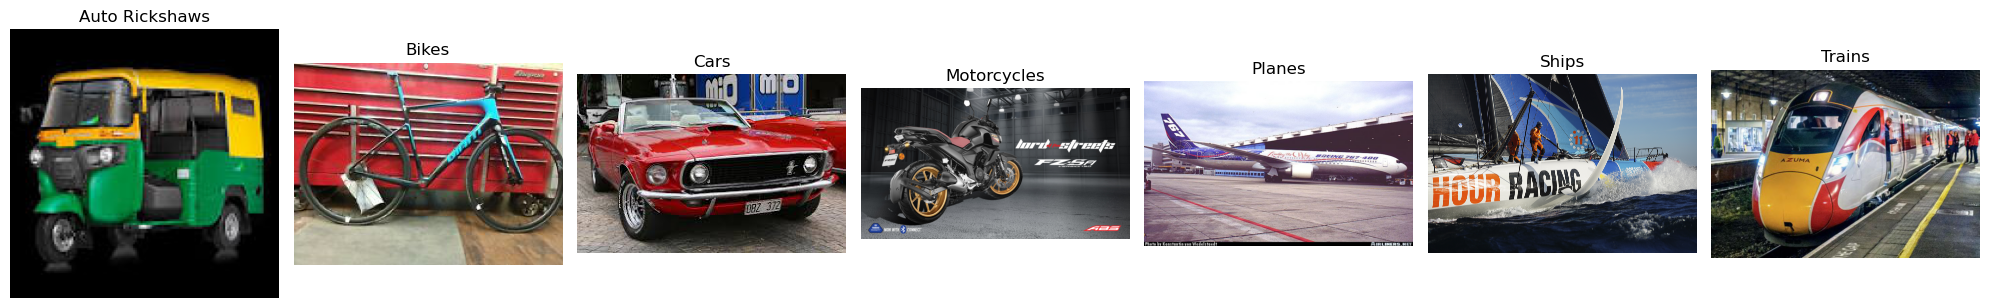

In [86]:
# Plot example images from each category
fig, axes = plt.subplots(1, len(sf_categories), figsize=(20, 5))

for ax, category in zip(axes, sf_categories):
    category_path = os.path.join(main_dir, category)
    image_files = os.listdir(category_path)
    
    if image_files:
        image_path = os.path.join(category_path, image_files[0])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')
    else:
        ax.set_title(category)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define a custom transformer for loading images
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(150, 150)):
        self.image_size = image_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        images = []
        for filepath in X:
            img = load_img(filepath, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
        return np.array(images)

In [ ]:
# Define a custom transformer for labeling images
class LabelExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        labels = [os.path.basename(os.path.dirname(filepath)) for filepath in X]
        return np.array(labels)

In [ ]:
# Get all image file paths from the dataset directory
def get_image_file_paths(dataset_path):
    file_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(root, file))
    return file_paths

In [ ]:
# Dataset directory
dataset_path = 'vehicles'

# Get file paths
file_paths = get_image_file_paths(dataset_path)

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('image_loader', ImageLoader(image_size=(150, 150))),  
    ('label_extractor', LabelExtractor())
])

c:\Users\Suvashin\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Apply the pipeline to the file paths
X = file_paths
X_preprocessed = pipeline.named_steps['image_loader'].transform(X)
y = pipeline.named_steps['label_extractor'].transform(X)

In [88]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [89]:
len(le.classes_)

7

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=123)

In [ ]:

images = np.array(X_train)
labels = np.array(y_encoded)

In [92]:
# Print the shapes of the arrays
print("Shape of images:", images.shape)
print("Label size:", labels.shape)

Shape of images: (4403, 150, 150, 3)
Label size: (5504,)


In [93]:
images = images / 255

In [94]:
model = Sequential()

model.add(Input(shape=(150, 150, 3)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

In [95]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 73, 73, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,255 (40.58 MB)

 Trainable params: 10,637,255 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [97]:
# Train the model
history = model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.3002 - loss: 2.6676 - val_accuracy: 0.6830 - val_loss: 0.9618
Epoch 2/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.7182 - loss: 0.8364 - val_accuracy: 0.7666 - val_loss: 0.7063
Epoch 3/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 157ms/step - accuracy: 0.8373 - loss: 0.4711 - val_accuracy: 0.8120 - val_loss: 0.6041
Epoch 4/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.9263 - loss: 0.2385 - val_accuracy: 0.7584 - val_loss: 0.7347
Epoch 5/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - accuracy: 0.9668 - loss: 0.1289 - val_accuracy: 0.7911 - val_loss: 0.7796
Epoch 6/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.9783 - loss: 0.0754 - val_accuracy: 0.8174 - val_loss: 0.7860
Epoch 7/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - accuracy: 0.9919 - loss: 0.0395 - val_accuracy: 0.8156 - val_loss: 0.9036


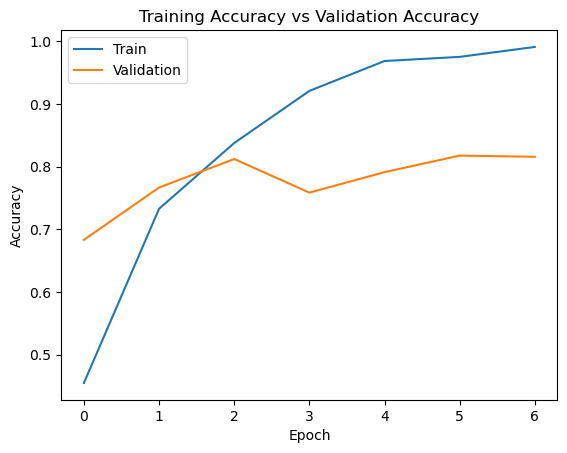

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

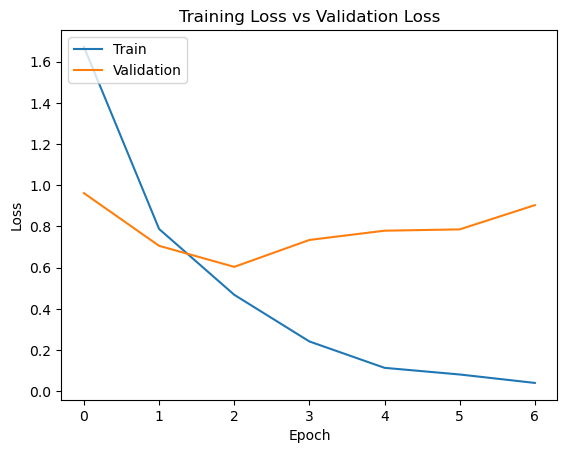

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


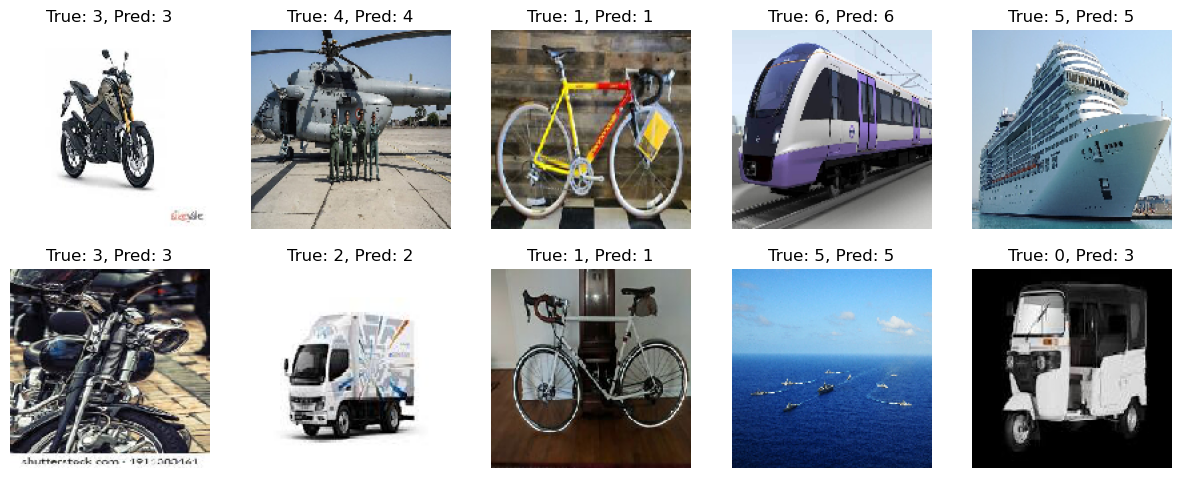

In [ ]:
def plot_predictions(X, y_true, y_pred, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        plt.axis('off')
    plt.show()


plot_predictions(X_test, Y_test, predicted_classes, num_samples=10)

In [101]:
accuracy = accuracy_score(Y_test, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 81.56%
